# Processing text in Python

The goal of this notebook is to provide a simple benchmark for the two text processing giants in Python: spaCy and NLTK. NLTK is written in pure Python, whereas spaCy is nearly entirely Cythonized.

Using text corpora of different sizes, we'll run a pipeline of processes: POS tagging, dependency parsing, and named entity recognition.

In [1]:
%matplotlib inline
import json
import math
from time import time
import matplotlib.pyplot as plt
from scipy import stats
from spacy.en import English
from nltk import pos_tag, ne_chunk, word_tokenize, sent_tokenize

nlp = English(parser=None)    # we're not benchmarking the parser, so don't include it in the pipline

I'm hiding the data pre-processing step here, but all I'm doing is taking 10 subsets of [*Dracula*](http://www.gutenberg.org/cache/epub/345/pg345.txt). Each subset is `n_chars` characters long, starting from the beginning of the book. `n_chars` increases by 3x for each subset (base case = 50 characters).

In [2]:
text_data = json.loads(open('dracula_subsets.json').read())

In [3]:
n_chars = [len(text) for text in text_data]

In [4]:
spacy = []
for text in text_data:
    times = []
    for _ in range(3):
        t1 = time()
        nlp(text)
        t2 = time()
        times.append(t2-t1)
    spacy.append(min(times))

In [5]:
nltk = []
for text in text_data:
    times = []
    for _ in range(3):
        t1 = time()
        sentences = [word_tokenize(sent) for sent in sent_tokenize(text)]
        for sent in sentences:
            ne_chunk(pos_tag(sent))
        t2 = time()
        times.append(t2-t1)
    nltk.append(min(times))

Here, I do a simple linear regression in log-log space as a sanity check:

In [6]:
log_chars = [math.log10(n) for n in n_chars]
log_spacy = [math.log10(t) for t in spacy]
log_nltk = [math.log10(t) for t in nltk]

In [7]:
m_spacy, b_spacy, r_spacy, _, _ = stats.linregress(log_chars, log_spacy)
m_spacy, b_spacy, r_spacy**2

(0.94228105434521259, -5.2804958862465332, 0.99326388884884698)

In [8]:
m_nltk, b_nltk, r_nltk, _, _ = stats.linregress(log_chars, log_nltk)
m_nltk, b_nltk, r_nltk**2

(0.98767465185067727, -4.128656373615148, 0.99941299366848546)

Really, the two previous cells tell the entire story:

- Tokenizing and tagging is linear in the size of the inputs, as we expect
- spaCy is an order of magnitude faster than NLTK for single-threaded looping over text documents

In [9]:
def reg_spacy(x):
    return (10 ** b_spacy) * (10 ** (m_spacy * math.log10(x)))

def reg_nltk(x):
    return (10 ** b_nltk) * (10 ** (m_nltk * math.log10(x)))

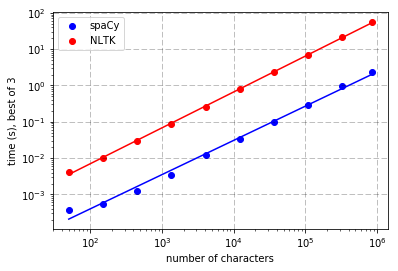

In [10]:
fig, ax = plt.subplots(dpi=300)

ax.set_xscale("log")
ax.set_yscale("log")

ax.scatter(n_chars, spacy, color='blue', label='spaCy')
ax.scatter(n_chars, nltk, color='red', label='NLTK')

ax.plot(n_chars, [reg_spacy(x) for x in n_chars], color='blue')
ax.plot(n_chars, [reg_nltk(x) for x in n_chars], color='red')

ax.set_xlabel('number of characters')
ax.set_ylabel('time (s), best of 3')
ax.grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
ax.legend()